In [ ]:
#pip install isodate
#pip install sentence_transformers
#pip install huggingface_hub[hf_xet]

In [2]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("cleaned.csv")

In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2') #pretrained semantic model

In [5]:
# join all variables with keywords into one variable called "text"
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["tags"].astype(str).fillna(""))

In [6]:
texts = df["text"].tolist()
embeddings = model.encode(texts, convert_to_tensor=True)

In [16]:
categories = {
    "Beauty": ["perfume", "lipstick", "foundation", "makeup", "tutorial", "shampoo", "conditioner", "haircare", "styling", "skincare", "moisturizer", "acne", "glow"],
    "Lifestyle": ["vlog", "daily routine", "wellness", "lifestyle", "aesthetic", "travel", "fashion", "day in my life", "productivity", "hobbies"],
    "Sports": ["workout", "upperbody", "sports", "fitness", "weightloss", "gym", "exercise", "running", "pickleball", "tennis"],
    "Health": ["health", "wellness", "diet", "nutrition", "exercise", "mental health", "yoga", "meditation", "healthy habits", "stress", "sleep"],
    "Food": ["cookbook", "food", "snacks", "cooking", "recipe", "cafe", "cafe hopping", "mealprep"]}

category_embeddings = model.encode(list(categories.values()), convert_to_tensor=True)

In [17]:
video_categories = []
for vid_emb in embeddings:
    sims = util.cos_sim(vid_emb, category_embeddings)[0]
    best_idx = torch.argmax(sims).item()
    video_categories.append(list(categories.keys())[best_idx])

df["semantic_category"] = video_categories

In [18]:
df['likeRatio'] = df['likeCount']/df['viewCount']
df['commentRatio'] = df['commentCount'] / df['viewCount']
df['SoE'] = (df['likeCount'] + df['commentCount']) / df['viewCount']

In [19]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"])
df["month"] = df["publishedAt"].dt.to_period("M")

trend_df = df.explode("semantic_category").groupby(["month", "semantic_category"]).agg({
    "viewCount": "sum",
    "SoE": "mean"
}).reset_index()

trend_df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15416\1635427534.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["publishedAt"].dt.to_period("M")


,month,semantic_category,viewCount,SoE
0,2020-01,Beauty,113439692.0,0.056118
1,2020-01,Food,594.0,0.037037
2,2020-01,Health,64808.0,0.062908
3,2020-01,Lifestyle,1772.0,0.053712
4,2020-01,Sports,153375.0,0.047375


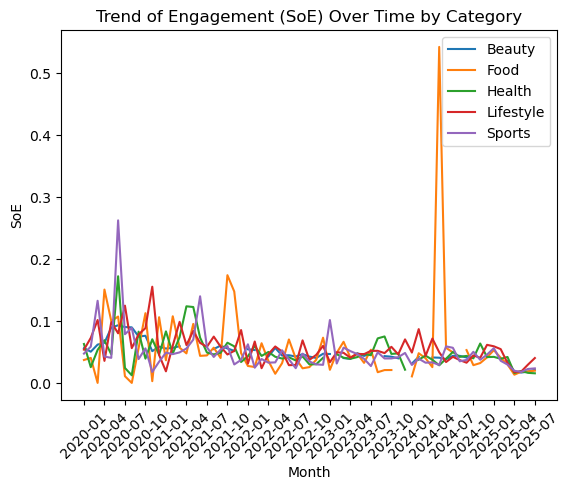

In [20]:
for cat in trend_df["semantic_category"].unique():
    subset = trend_df[trend_df["semantic_category"] == cat]
    plt.plot(subset["month"].astype(str), subset["SoE"], label=cat)

plt.xticks(subset["month"].astype(str)[::3], rotation=45) 
plt.legend()
plt.title("Trend of Engagement (SoE) Over Time by Category")
plt.xlabel("Month")
plt.ylabel("SoE")
plt.show()